<a href="https://colab.research.google.com/github/aayushbhurtel/2143-OOP-Aayush/blob/main/Autoencoder_with_FASHION_MNIST_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

lets load a FASHION MNIST dataset

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K


Variables

In [ ]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5

Load these data

In [ ]:
(x_train,y_train), (x_test,y_test) = datasets.fashion_mnist.load_data()

out of the box we get 28x28 size images and we need to change into 32x32 and make sure the pixel between 0 and 1.

In [ ]:
# Preprocess the data


def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

lets understand autoencoder architecture and code it up.

autoencoder is a neural network made up of two parts:
1. encoder : An encoder network that compresses high-dimensional input data such as an image into a lower-dimensional embedding vector
2. decoder : A decoder network that decompresses a given embedding vector back to the original domain (e.g., back to an image)

ENCODER -> z -> DECODER

An input image is encoded to a latent embedding vector "z", which is then decoded back to the original pixel space.

To achieve this, we first create an Input layer for the image and pass this through three Conv2D layers in sequence, each capturing increasingly high-level features. We use a stride of 2 to halve the size of the output of each layer, while increasing the number of channels. The last convolutional layer is flattened and connected to a Dense layer of size 2, which represents our two-dimensional latent space.

First lets code the input layer of encoder


In [ ]:
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)

Stack Conv2D layers sequentially on top of each other

In [ ]:
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)

Flatten the last convolutional layer to a vector.

In [ ]:
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)

Connect this vector to the 2D embeddings with a Dense layer.



In [ ]:
encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)

The Keras Model that defines the encoder—a model that takes an input image and encodes it into a 2D embedding.



In [ ]:
encoder = models.Model(encoder_input, encoder_output)

lets see the summary of encoder

In [ ]:
encoder.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)

Now lets code a decoder.

The decoder is a mirror image of the encoder—instead of convolutional layers, we use convolutional transpose layers.



In [ ]:
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    CHANNELS,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_12             │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_13             │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_14             │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

the full autoencoder

In [ ]:
autoencoder = models.Model(
    encoder_input, decoder(encoder_output)
)  # decoder(encoder_output)
autoencoder.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_12 (Functional)      │ (None, 32, 32, 1)      │       246,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,043 (1.31 MB)

 Trainable params: 343,043 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

Compile the autoencoder.

choosing the loss function is another important aspect of modeling a neural network.

In [ ]:
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

Create a model save checkpoint

In [ ]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./keras.keras",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

training the autoencoder

In [ ]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 201s 329ms/step - loss: 0.3571 - val_loss: 0.2610
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 212s 347ms/step - loss: 0.2589 - val_loss: 0.2584
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 248s 324ms/step - loss: 0.2553 - val_loss: 0.2553
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 205s 330ms/step - loss: 0.2527 - val_loss: 0.2528
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 205s 335ms/step - loss: 0.2508 - val_loss: 0.2521


reconstruct using autoencoder.

We can test the ability to reconstruct images by passing images from the test set through the autoencoder and comparing the output to the original images.

In [ ]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [ ]:
predictions = autoencoder.predict(example_images)

print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(predictions)

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step
Example real clothing items


array([[[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.        ],
         [0.        ],
         [0.  

Reconstructions


array([[[[7.82112766e-05],
         [6.64683694e-06],
         [3.17440135e-05],
         ...,
         [1.25936785e-05],
         [1.09625671e-05],
         [3.36643861e-04]],

        [[3.74773163e-06],
         [3.26649172e-07],
         [3.37675215e-06],
         ...,
         [8.09004064e-07],
         [5.98740542e-07],
         [2.43238937e-05]],

        [[1.45531349e-05],
         [2.65416065e-06],
         [2.51813926e-05],
         ...,
         [1.33898684e-05],
         [3.21986181e-06],
         [3.57263707e-05]],

        ...,

        [[1.01591991e-06],
         [1.56893577e-07],
         [6.94203322e-07],
         ...,
         [9.71318248e-10],
         [7.16699700e-10],
         [2.92398539e-07]],

        [[4.76528476e-06],
         [5.15013028e-07],
         [1.07707694e-06],
         ...,
         [2.18640519e-08],
         [7.67736275e-09],
         [9.24050767e-07]],

        [[3.79308243e-04],
         [1.44456179e-04],
         [1.61062519e-04],
         ...,
 

Embed using the encoder

Encode the example images

In [ ]:
embeddings = encoder.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


some examples of the embeddings

In [ ]:
print(embeddings[:10])

[[-0.8002563  -2.2498665 ]
 [ 5.928301   -1.2850255 ]
 [ 2.4755003   5.9666424 ]
 [ 1.0019405   3.478369  ]
 [ 2.7093124  -1.0655813 ]
 [ 2.5927691   3.9237397 ]
 [ 1.6733571   0.05084707]
 [ 2.3989468  -0.5547825 ]
 [-3.4583523  -1.715239  ]
 [-3.2086406  -3.7183242 ]]


Show the encoded points in 2D space


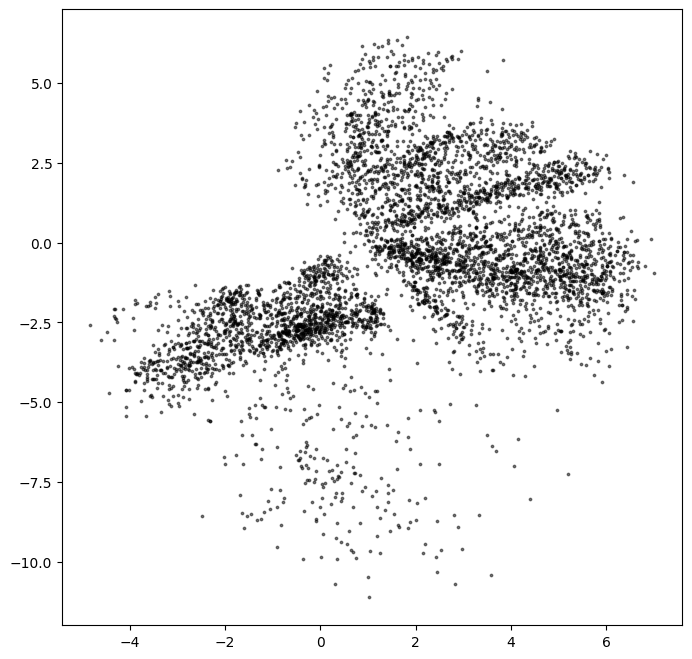

In [ ]:
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

Colour the embeddings by their label
Each training and test example is assigned to one of the following labels:

0 T-shirt/top <br>
1 Trouser <br>
2 Pullover<br>
3 Dress<br>
4 Coat<br>
5 Sandal<br>
6 Shirt<br>
7 Sneaker<br>
8 Bag<br>
9 Ankle boot<br>

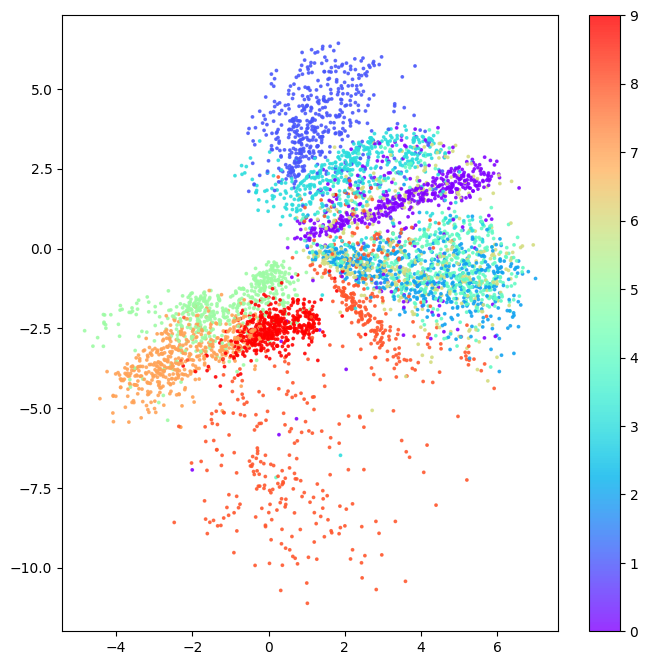

In [ ]:
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

Generate using decoder

Get the range of the existing embeddings

In [ ]:
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)


Sample some points in the latent space

In [ ]:
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)

Decode the sampled points


In [ ]:
reconstructions = decoder.predict(sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Original Images

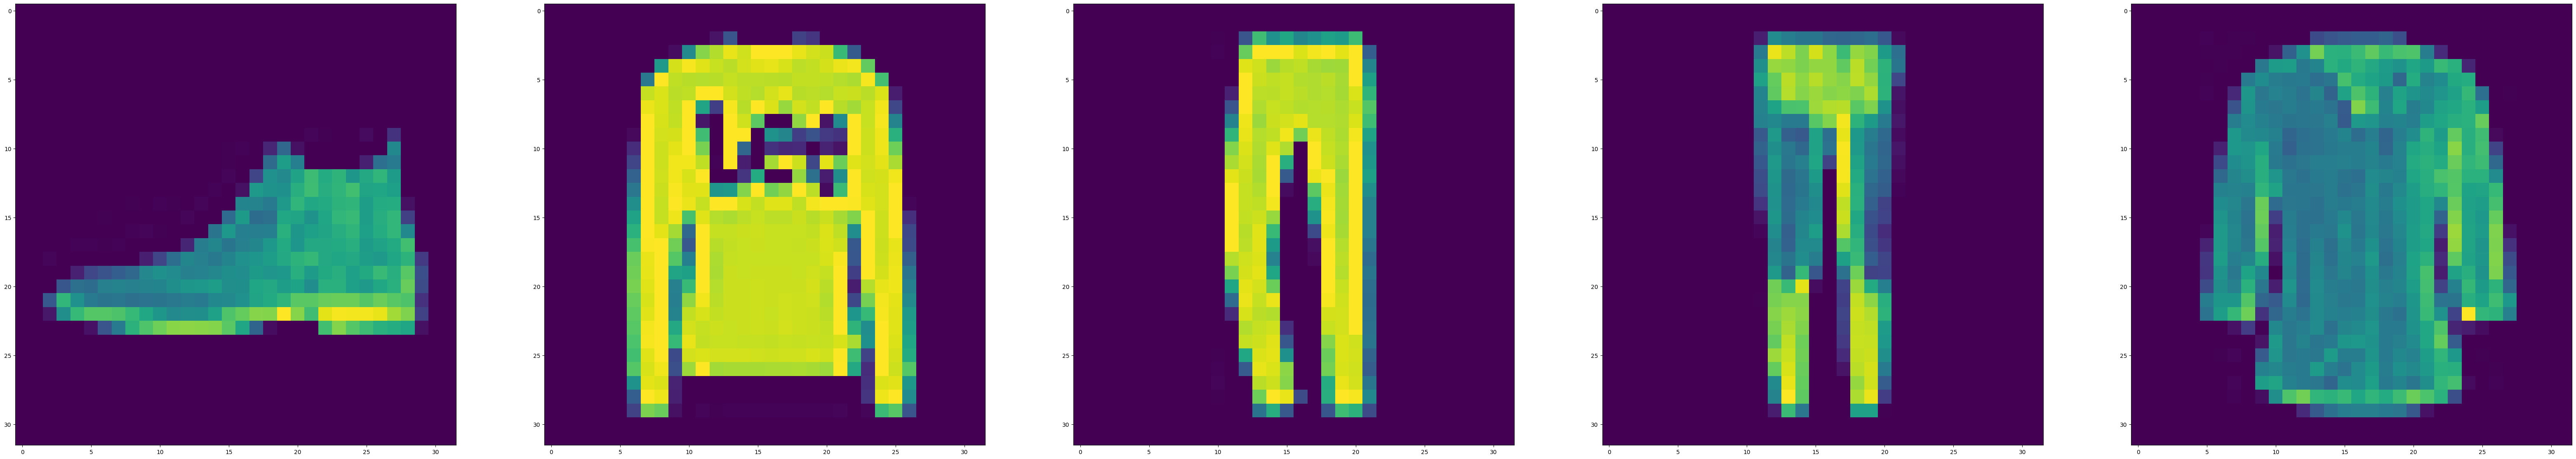

In [ ]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5):
    ax[i].imshow(x_test[i].reshape(32, 32))
plt.show()

Constructed Images

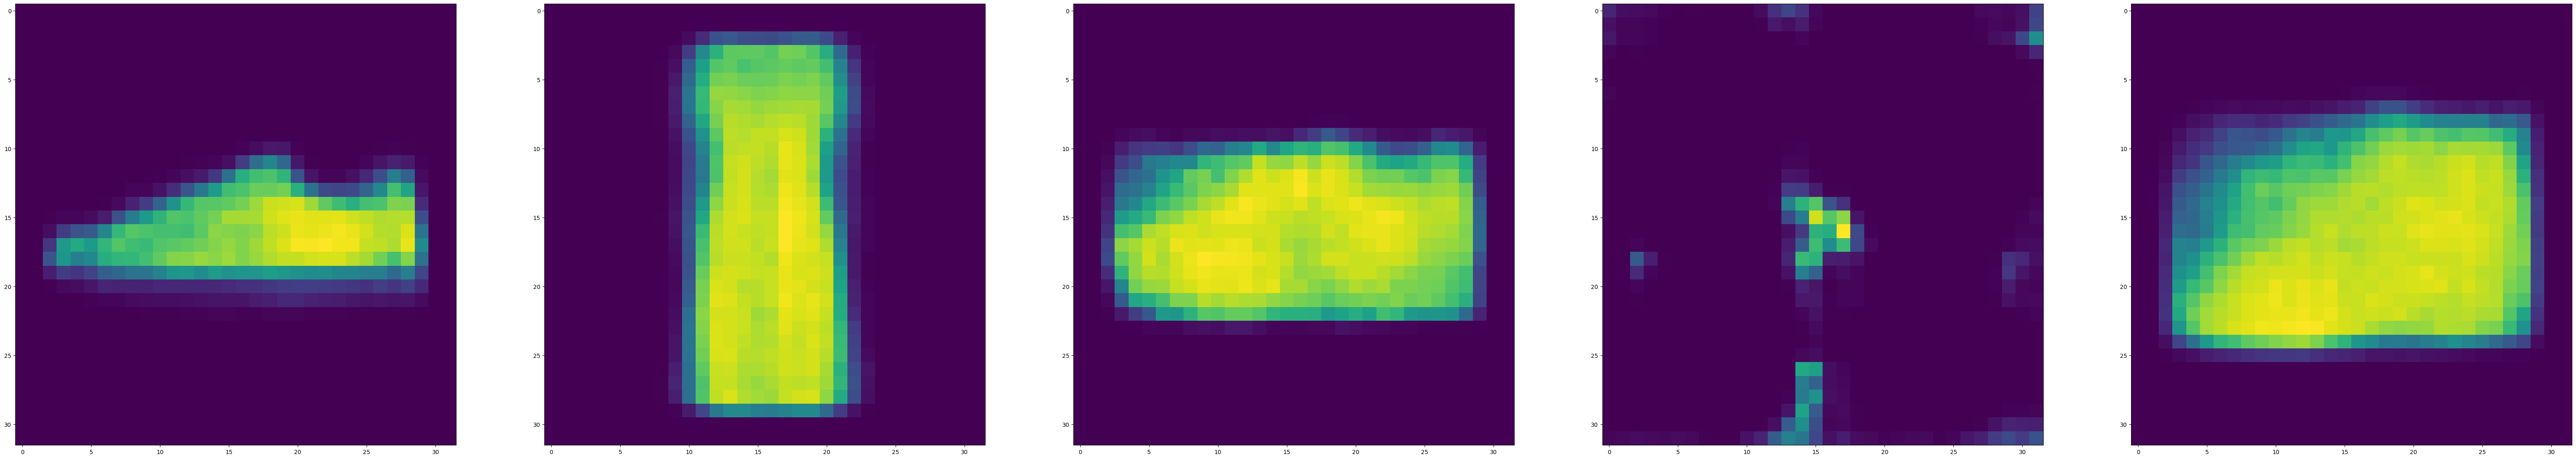

In [ ]:
from PIL import Image
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5):
    ax[i].imshow(reconstructions[i].reshape(32, 32))
plt.show()